In [38]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import wandb
import matplotlib.pyplot as plt


from models.resnet.resnet18 import ResNet18
from models.moe_layer.soft_gating_networks import SimpleGate
from datasets.cifar100_dataset import CIFAR100Dataset
from utils.dataset_utils import train_test_split, get_transformation
from utils.cifar100_utils import CIFAR100_LABELS, CIFAR100_DECODING, CIFAR100_ENCODING

In [2]:
runpaths = ['lukas-struppek/final_resnet_18/3qp2c0vg', 'lukas-struppek/final_resnet_18/2i3oi5fi', 'lukas-struppek/final_resnet_18/qropxr6y']
filenames = ['Baseline_0_schedule_0_final.tar', 'Baseline_1_schedule_0_final.tar', 'Baseline_2_schedule_0_final.tar']

In [3]:
models = []
for i in range(3):
    model = ResNet18(CIFAR100_LABELS, name='Baseline_' + str(i))

    # Load model weights
    file_model = wandb.restore(filenames[i], run_path=runpaths[i], root='./model_weights')

    # # Load parameters
    model.load_state_dict(torch.load(file_model.name)['model_state_dict'])

    # # Move model to cuda
    model.to(model.device)

    models.append(model)


In [4]:
# Loading datasets
transformations_test = get_transformation('cifar100', phase='test')
test_data = CIFAR100Dataset(
    root_dir='/home/lb4653/mixture-of-experts-thesis/data/cifar100/testing', transform=transformations_test)


In [5]:
models[0].evaluate(test_data)

------------------------------------ Beginning Evaluation ------------------------------------
Evaluation of  Baseline_0
Evaluation on 10,000 samples
Evaluation complete in  00:00:03
Evaluation Accuracy: 0.7259
------------------------------------ Finished Evaluation ------------------------------------



{'loss': tensor(1.9431),
 'aux_loss': tensor(0.),
 'acc': 0.7259,
 'examples_cof': tensor(0.),
 'importance_cof': tensor(0.)}

In [6]:
dataloader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=False)
y_true = np.empty(0)
y_pred = np.empty(0)
for model in models:
    for image, label in dataloader:
        image = image.to('cuda:0')
        y_true = np.append(y_true, label.cpu().numpy())
        y_pred = np.append(y_pred, torch.argmax(models[0](image), dim=1).cpu().numpy())
y_true = y_true.astype(int)
y_pred = y_pred.astype(int)

In [7]:
transform = lambda x: CIFAR100_DECODING[x]

In [8]:
y_true = [CIFAR100_DECODING[x] for x in y_true]
y_pred = [CIFAR100_DECODING[x] for x in y_pred]

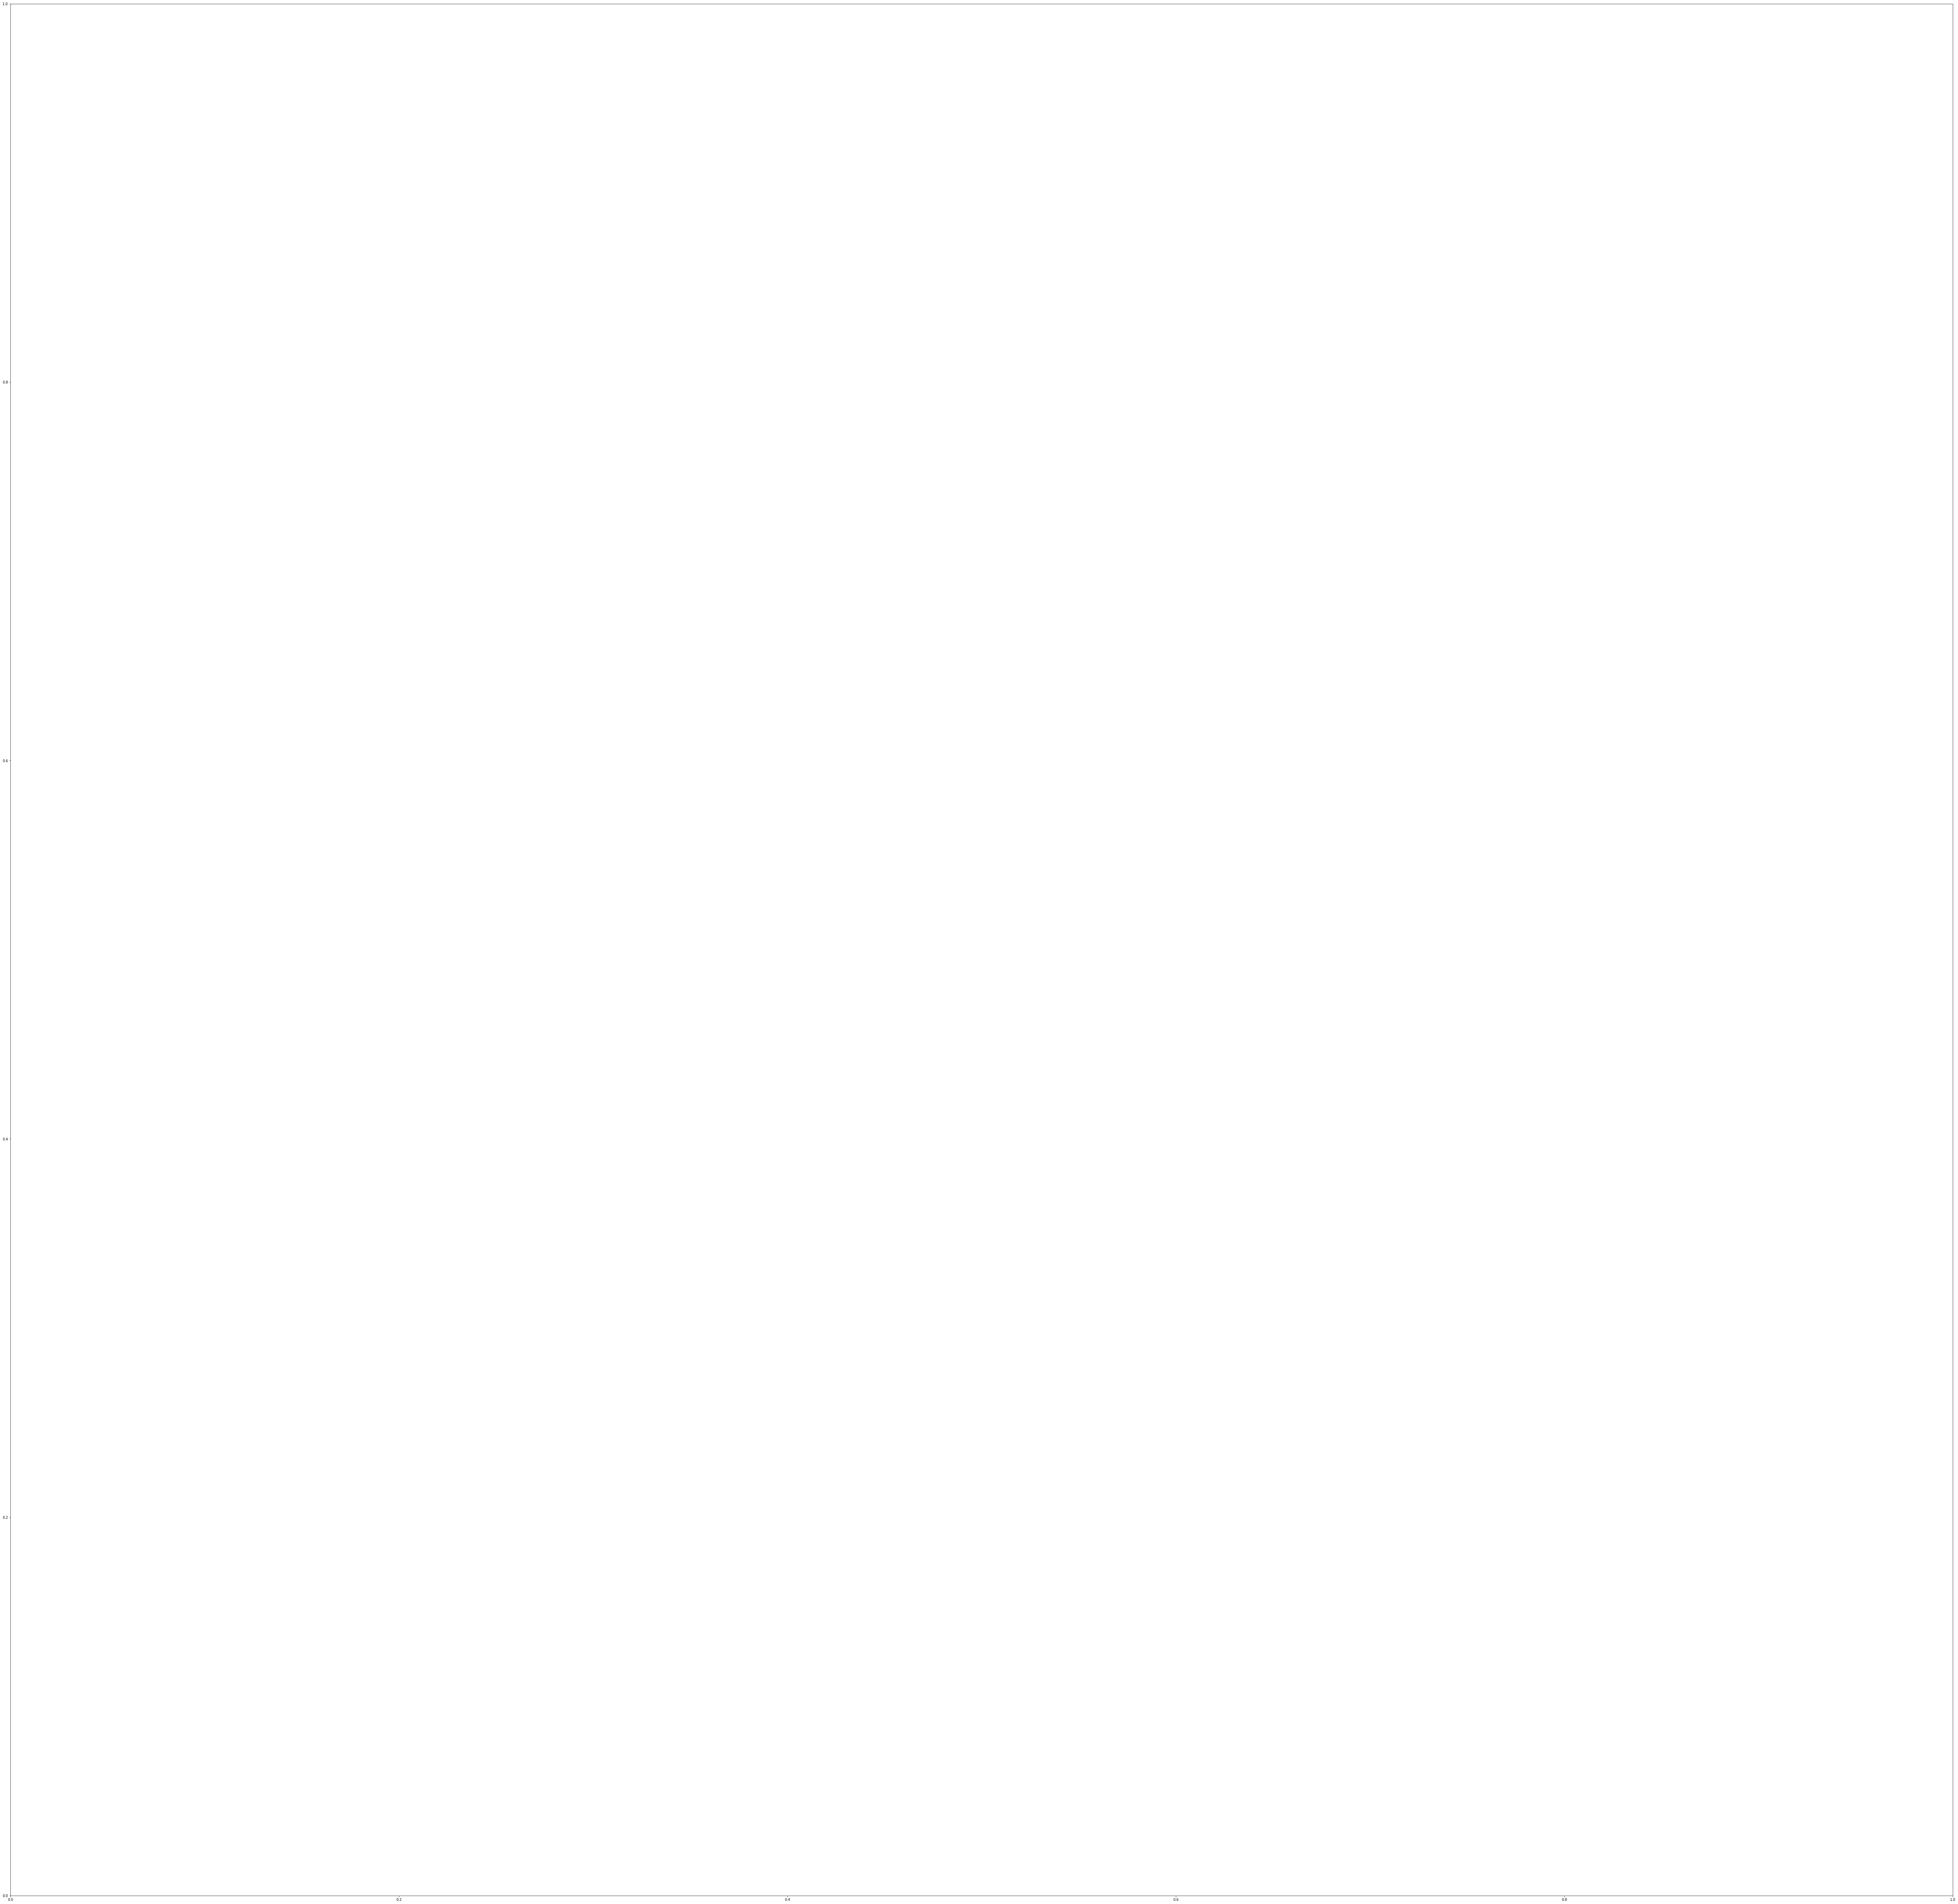

In [9]:
from utils.plot_confusion_matrix import plot_confusion_matrix
plot_confusion_matrix(y_true, y_pred, CIFAR100_LABELS, figsize=(100, 100))

In [55]:
df = pd.read_csv('confusion_matrix.csv')
df.head()

,Actual,apple,aquarium_fish,baby,bear,beaver,bed,bee,beetle,bicycle,...,train,trout,tulip,turtle,wardrobe,whale,willow_tree,wolf,woman,worm
0,apple,267,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
1,aquarium_fish,0,249,0,0,0,0,0,0,0,...,0,3,3,0,0,0,0,0,0,0
2,baby,0,3,186,3,0,3,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,bear,0,0,0,168,12,0,3,0,0,...,0,0,0,0,0,0,0,3,0,0
4,beaver,0,0,0,3,156,0,0,3,0,...,0,3,0,0,0,0,0,3,0,0


In [56]:
df.columns = df.columns.to_series().apply(lambda x: CIFAR100_ENCODING[x])
df.index = df.index.to_series().apply(lambda x: CIFAR100_ENCODING[x])

AttributeError: 'RangeIndex' object has no attribute 'apply'

In [53]:
df.head()

,100,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
100,apple,267,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
100,aquarium_fish,0,249,0,0,0,0,0,0,0,...,0,3,3,0,0,0,0,0,0,0
100,baby,0,3,186,3,0,3,0,0,0,...,0,0,0,0,0,0,0,0,3,0
100,bear,0,0,0,168,12,0,3,0,0,...,0,0,0,0,0,0,0,3,0,0
100,beaver,0,0,0,3,156,0,0,3,0,...,0,3,0,0,0,0,0,3,0,0


In [49]:
df.astype(int).idxmax(axis=1)

ValueError: invalid literal for int() with base 10: 'apple'